In [42]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, classification_report
from tqdm.auto import tqdm
from collections import Counter

In [43]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda
cuda


In [44]:
# set seed for reproducibilty
SEED = 50

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [45]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # root directory where the food-11 zip file is located
# root_dir = 'drive/MyDrive/'

**DATA PREPROCESSING AND VISUALIZATION**

In [46]:
# # extract the food-11 zip file
# with zipfile.ZipFile('google_stock_price.zip', 'r') as zip_ref:
#     zip_ref.extractall('google_stock_price/')

In [47]:
df = pd.read_csv('GOOG.csv')
df.head(10)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104,2.640104
5,26-08-2004,2.606729,2.613952,142572401,2.688672,2.687676,2.687676
6,27-08-2004,2.632383,2.692408,124826132,2.705360,2.643840,2.643840
7,30-08-2004,2.540727,2.622171,104429967,2.627402,2.540727,2.540727
8,31-08-2004,2.544463,2.547950,98825037,2.583068,2.549693,2.549693
9,01-09-2004,2.482445,2.557912,183633734,2.564637,2.496891,2.496891


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104,2.640104
5,26-08-2004,2.606729,2.613952,142572401,2.688672,2.687676,2.687676
6,27-08-2004,2.632383,2.692408,124826132,2.705360,2.643840,2.643840
7,30-08-2004,2.540727,2.622171,104429967,2.627402,2.540727,2.540727
8,31-08-2004,2.544463,2.547950,98825037,2.583068,2.549693,2.549693
9,01-09-2004,2.482445,2.557912,183633734,2.564637,2.496891,2.496891


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612 entries, 0 to 4611
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4612 non-null   object 
 1   Low             4612 non-null   float64
 2   Open            4612 non-null   float64
 3   Volume          4612 non-null   int64  
 4   High            4612 non-null   float64
 5   Close           4612 non-null   float64
 6   Adjusted Close  4612 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 252.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612 entries, 0 to 4611
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4612 non-null   object 
 1   Low             4612 non-null   float64
 2   Open            4612 non-null   float64
 3   Volume          4612 non-null   int64  
 4   High            4612 non-null   float64
 5  

In [49]:
# data pre-processing
#train_df['Volume'] = train_df['Volume'].str.replace(',', '')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
#train_df.dropna(inplace=True)

scaler = StandardScaler()

scaled_data = scaler.fit_transform(df)

In [50]:
train_length = int(len(scaled_data)*0.8)

train_scaled_data = scaled_data[:train_length]
test_scaled_data = scaled_data[train_length:]

print(train_scaled_data.shape)
print(test_scaled_data.shape)

(3689, 5)
(923, 5)
(3689, 5)
(923, 5)


In [51]:
# test_df = pd.read_csv('google_stock_price/Google_Stock_Price_Test.csv')
# test_df.head(10)

In [52]:
class StockDataset(Dataset):
    def __init__(self, data, N):

        self.data = data

        self.N = N

    def __len__(self):
        return len(self.data) - self.N

    def __getitem__(self, idx):
        # Get the sequence of features for the last N days
        x = self.data[idx:idx + self.N, :]
        # Get the closing price of the next day as the target
        y = self.data[idx + self.N, 3]

        # Convert to PyTorch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y

In [53]:
# Define your parameters
N = 30  # Number of days to look back
batch_size = 32  # Batch size for DataLoader

# Instantiate the dataset
train_data = StockDataset(train_scaled_data, N)
test_data = StockDataset(test_scaled_data, N)

In [54]:
# Create the DataLoader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [55]:
x,y = next(iter(train_dataloader))

print(x.shape,y.shape)

torch.Size([32, 30, 5]) torch.Size([32])
torch.Size([32, 30, 5]) torch.Size([32])


**TRAINING**

In [56]:
# function to train the model
def train(model, dataloader, criterion, optimizer):
    model.train()    # Set the model to training mode

    epoch_loss = 0  # Accumulate loss for each epoch

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        preds = model(x)
        preds = preds.squeeze()  # Ensure predictions have the same shape as y_batch

        # Compute the loss
        loss = criterion(preds, y)

        optimizer.zero_grad()  # Zero the gradients

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        epoch_loss += loss.item()

    # Print the average loss for each epoch
    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

In [57]:
# function to test the model
def test(model, dataloader, criterion):
    model.eval()

    epoch_loss = 0  # Accumulate loss for each epoch

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            # Forward pass
            preds = model(x)
            preds = preds.squeeze()  # Ensure predictions have the same shape as y_batch

            # Compute the loss
            loss = criterion(preds, y)

            # Accumulate loss for reporting
            epoch_loss += loss.item()

    # Print the average loss for each epoch
    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

In [58]:
# function to plot the predicted values and actual values
def evaluate(model, dataset):
    actual_price = []
    pred_price = []

    model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            x,y = dataset[i]
            x, y = x.to(device), y.to(device)

            # add a batch dimension
            x = x.unsqueeze(0)

            pred = model(x).squeeze()

            actual_price.append(y.item())
            pred_price.append(pred.item())

    plt.figure(figsize=(12, 6))
    plt.plot(actual_price, label='Actual Stock Prices', color='red')
    plt.plot(pred_price, label='Predicted Stock Prices', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Actual vs. Predicted Stock Prices')
    plt.legend()
    plt.show()

**BASELINE**

In [59]:
class Baseline(nn.Module):
    def __init__(self, feature_size, hidden_dim):

        super().__init__()

        self.rnn = nn.RNN(feature_size,
                          hidden_dim,
                          batch_first=True)

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        # x = [batch size, seq len, feature size]

        output, hidden = self.rnn(x)

        hidden = hidden.squeeze()

        out = self.fc(hidden)

        return out

In [60]:
feature_size = 5
hidden_dim = 16

model = Baseline(feature_size, hidden_dim).to(device)

In [61]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [62]:
epochs = 100

In [22]:
for epoch in range(epochs):

    # Print the average loss for each epoch
    train_loss = train(model, train_dataloader, criterion, optimizer)
    #test_loss = test(model, test_dataloader, criterion)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f}")

Epoch 10 | Train Loss: 0.000294
Epoch 20 | Train Loss: 0.000216
Epoch 30 | Train Loss: 0.000201
Epoch 40 | Train Loss: 0.000181
Epoch 50 | Train Loss: 0.000174
Epoch 60 | Train Loss: 0.000164
Epoch 70 | Train Loss: 0.000174
Epoch 80 | Train Loss: 0.000160
Epoch 90 | Train Loss: 0.000158
Epoch 100 | Train Loss: 0.000156
Epoch 10 | Train Loss: 0.000294
Epoch 20 | Train Loss: 0.000216
Epoch 30 | Train Loss: 0.000201
Epoch 40 | Train Loss: 0.000181
Epoch 50 | Train Loss: 0.000174
Epoch 60 | Train Loss: 0.000164
Epoch 70 | Train Loss: 0.000174


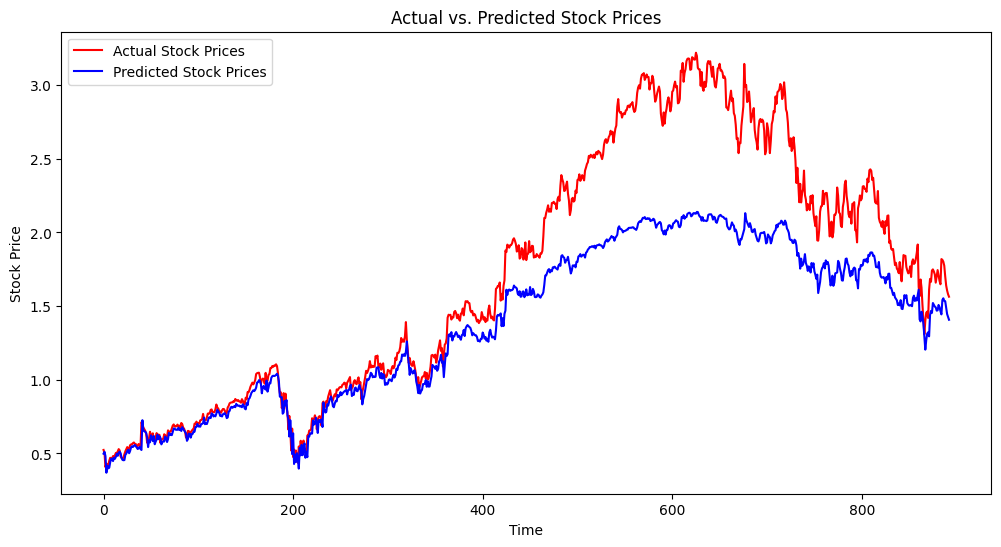

In [23]:
evaluate(model, test_data)

**LSTM**

In [24]:
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers):

        super().__init__()

        self.rnn = nn.LSTM(feature_size,
                           hidden_dim,
                           batch_first=True,
                           num_layers=num_layers)

        self.fc = nn.Linear(hidden_dim*2, 1)

    def forward(self, x):

        # x = [batch size, seq len, feature size]

        output, (hidden,cell) = self.rnn(x)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out = self.fc(hidden)

        return out

In [25]:
feature_size = 5
hidden_dim = 64
num_layers = 2

model = LSTM(feature_size, hidden_dim, num_layers).to(device)

In [26]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [27]:
epochs = 100

In [28]:
for epoch in range(epochs):

    # Print the average loss for each epoch
    train_loss = train(model, train_dataloader, criterion, optimizer)
    #test_loss = test(model, test_dataloader, criterion)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f}")

Epoch 10 | Train Loss: 0.000342
Epoch 20 | Train Loss: 0.000261
Epoch 30 | Train Loss: 0.000211
Epoch 40 | Train Loss: 0.000189
Epoch 50 | Train Loss: 0.000203
Epoch 60 | Train Loss: 0.000168
Epoch 70 | Train Loss: 0.000159
Epoch 80 | Train Loss: 0.000160
Epoch 90 | Train Loss: 0.000165
Epoch 100 | Train Loss: 0.000150


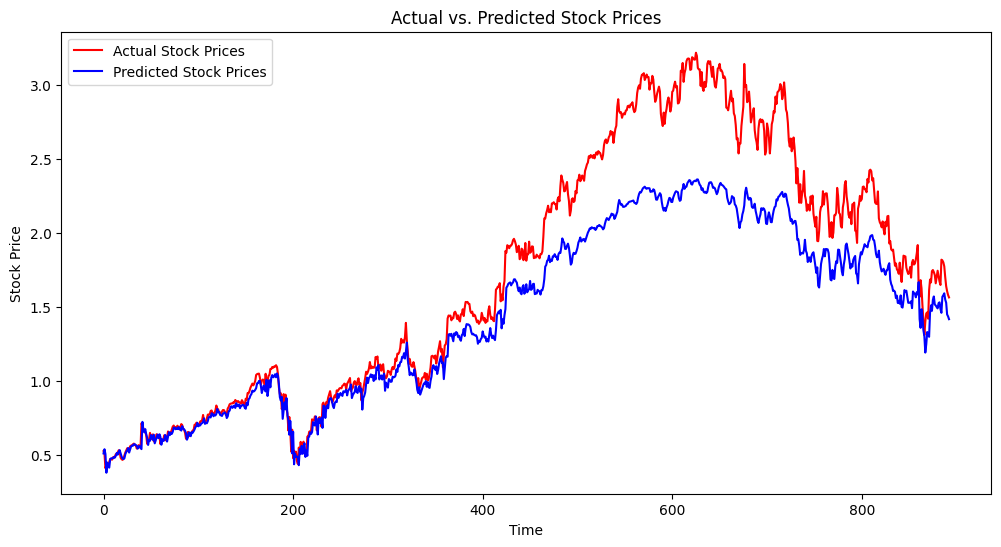

In [29]:
evaluate(model, test_data)

**GRU**

In [30]:
class GRU(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers):

        super().__init__()

        self.rnn = nn.GRU(feature_size,
                           hidden_dim,
                           batch_first=True,
                           num_layers=num_layers)

        self.fc = nn.Linear(hidden_dim*2, 1)

    def forward(self, x):

        # x = [batch size, seq len, feature size]

        output, hidden = self.rnn(x)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out = self.fc(hidden)

        return out

In [31]:
feature_size = 5
hidden_dim = 64
num_layers = 2

model = GRU(feature_size, hidden_dim, num_layers).to(device)

In [32]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [33]:
epochs = 100

In [34]:
for epoch in range(epochs):

    # Print the average loss for each epoch
    train_loss = train(model, train_dataloader, criterion, optimizer)
    #test_loss = test(model, test_dataloader, criterion)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f}")

Epoch 10 | Train Loss: 0.000245
Epoch 20 | Train Loss: 0.000215
Epoch 30 | Train Loss: 0.000191
Epoch 40 | Train Loss: 0.000174
Epoch 50 | Train Loss: 0.000169
Epoch 60 | Train Loss: 0.000166
Epoch 70 | Train Loss: 0.000179
Epoch 80 | Train Loss: 0.000151
Epoch 90 | Train Loss: 0.000160
Epoch 100 | Train Loss: 0.000160


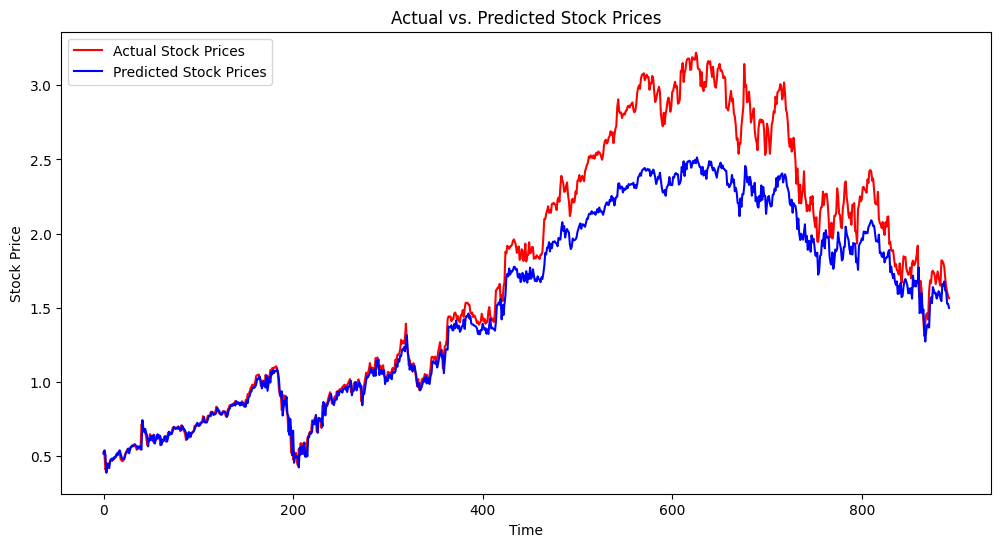

In [35]:
evaluate(model, test_data)

**GRU WITH ATTENTION**

In [36]:
class GRUAttention(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers):

        super().__init__()

        self.rnn = nn.GRU(feature_size,
                           hidden_dim,
                           batch_first=True,
                           num_layers=num_layers)

        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        # x = [batch size, seq len, feature size]

        output, hidden = self.rnn(x)

        Q = self.query(output)  # Query: [batch size, seq len, hidden_dim]
        K = self.key(output)    # Key:   [batch size, seq len, hidden_dim]
        V = self.value(output)  # Value: [batch size, seq len, hidden_dim]

        # Scaled dot-product attention
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (hidden.size(2) ** 0.5)  # [batch size, seq len, seq len]
        attention_weights = torch.softmax(attention_scores, dim=2)  # [batch size, seq len, seq len]

        context = torch.bmm(attention_weights, V)  # [batch size, seq len, hidden_dim]

        # Summing context vector across the sequence length
        context = context.mean(dim=1)  # [batch size, hidden_dim]

        out = self.fc(context)

        return out

In [37]:
feature_size = 5
hidden_dim = 64
num_layers = 2

model = GRUAttention(feature_size, hidden_dim, num_layers).to(device)

In [38]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [39]:
epochs = 100

In [40]:
for epoch in range(epochs):

    # Print the average loss for each epoch
    train_loss = train(model, train_dataloader, criterion, optimizer)
    #test_loss = test(model, test_dataloader, criterion)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f}")

Epoch 10 | Train Loss: 0.001326
Epoch 20 | Train Loss: 0.000382
Epoch 30 | Train Loss: 0.000232
Epoch 40 | Train Loss: 0.000212
Epoch 50 | Train Loss: 0.000205
Epoch 60 | Train Loss: 0.000179
Epoch 70 | Train Loss: 0.000198
Epoch 80 | Train Loss: 0.000155
Epoch 90 | Train Loss: 0.000181
Epoch 100 | Train Loss: 0.000179


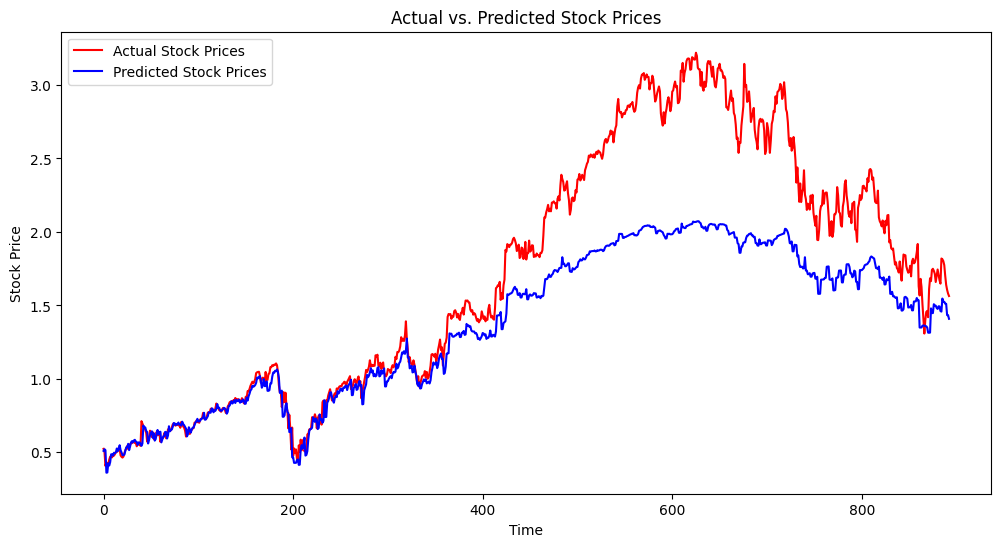

In [41]:
evaluate(model, test_data)